# Simple Train

This Notebook is written to provide a self-contained overview over the data and network loading and training

It is organized in three parts

1. Creation of a fake dataset with random values
2. Loading this dataset using the Tensorflows [Dataset API](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)
3. Performing one training step

## load packages

In [72]:
import numpy as np
from S2parser_africa import S2parser
import os
import gzip
import shutil
import tensorflow as tf
import pickle
import h5py

from scipy.misc import imresize

parser=S2parser()

## 1. Create dataset

In [73]:
hdf5_filepath = '/home/roserustowicz/croptype_data_local/data/ghana/data.hdf5'
grid_dir = '/home/roserustowicz/croptype_data_local/data/ghana'
num_classes = 4
numpix = 24

use_s2 = True
country = 'ghana'
dataset = 'full'

S2_BAND_MEANS = { 'ghana': np.array([2620.00, 2519.89, 2630.31, 2739.81, 3225.22, 3562.64, 3356.57, 3788.05, 2915.40, 2102.65]),
                  'southsudan': np.array([2119.15, 2061.95, 2127.71, 2277.60, 2784.21, 3088.40, 2939.33, 3308.03, 2597.14, 1834.81]),
                  'tanzania': np.array([2551.54, 2471.35, 2675.69, 2799.99, 3191.33, 3453.16, 3335.64, 3660.05, 3182.23, 2383.79])}

S2_BAND_STDS = { 'ghana': np.array([2171.62, 2085.69, 2174.37, 2084.56, 2058.97, 2117.31, 1988.70, 2099.78, 1209.48, 918.19]),
                 'southsudan': np.array([2113.41, 2026.64, 2126.10, 2093.35, 2066.81, 2114.85, 2049.70, 2111.51, 1320.97, 1029.58]),
                 'tanzania': np.array([2290.97, 2204.75, 2282.90, 2214.60, 2182.51, 2226.10, 2116.62, 2210.47, 1428.33, 1135.21])}

MIN_TIMESTAMPS = 25

In [74]:
def write_field_sample(hdf5_filepath, filepath, country): 
    grid_id = filepath.split('/')[-1].replace(".tfrecord", "")
    with h5py.File(hdf5_filepath, 'r') as data:
        s2 = None
        s2_doy = None

        s2 = data['s2'][grid_id]
        s2_doy = data['s2_dates'][grid_id][()]
        s2, s2_doy, _ = sample_timeseries(s2, MIN_TIMESTAMPS, dates=s2_doy, sample_w_clouds=False)

        year = (np.ones((len(s2_doy), )) * 2017).astype(int)
        
        grid = moveTimeToStart(s2)
        grid = np.transpose(grid, (0, 2, 3, 1))
        #grid = grid[:, :numpix, :numpix, :]      
        grid = np.resize(grid, new_shape=(grid.shape[0], numpix, numpix, grid.shape[3]))
        print('grid: ', grid.shape)
        
        label = data['labels'][grid_id][()]
        label[label > num_classes] = 0  
        label = np.resize(label, new_shape=(numpix, numpix))
        label = np.expand_dims(label, axis=0)
        print('label: ', label.shape)
        
    parser = S2parser()
    parser.write(filepath, grid, s2_doy, year, label)

In [75]:
def write_random_sample(filepath,nobs=46, pix10=24, bands10=4, pix20=12, bands20=6, pix60=6, bands60=3):
    """create a fake sample with random values"""
    x10 = (np.random.random([nobs,pix10,pix10,bands10])*1e4).astype(np.int64)
    x20 = (np.random.random([nobs,pix20,pix20,bands20])*1e4).astype(np.int64)
    x60 = (np.random.random([nobs,pix60,pix60,bands60])*1e4).astype(np.int64)
    doy = (np.random.random([nobs])*365).astype(np.int64)
    year = np.round(np.random.random([nobs])+2016.5).astype(np.int64)
    label = (np.random.random([nobs,pix10,pix10])*17).astype(np.int64)

    # create instance of parser
    parser = S2parser()

    # write .tfrecord
    parser.write(filepath, x10, x20, x60, doy, year, label)

def ziptfrecord(infile,outfile):
    # gzip .tfrecord to .tfrecord.gz
    with open(infile, 'rb') as f_in:
        with gzip.open(outfile, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

In [76]:
def normalization(grid, country):
    """ Normalization based on values defined in constants.py
    Args: 
      grid - (tensor) grid to be normalized
      satellite - (str) describes source that grid is from ("s1" or "s2")

    Returns:
      grid - (tensor) a normalized version of the input grid
    """
    num_bands = grid.shape[0]
    s2_band_means = S2_BAND_MEANS[country]
    s2_band_stds = S2_BAND_STDS[country]
    grid = (grid-s2_band_means[:num_bands].reshape(num_bands, 1, 1, 1))/s2_band_stds[:num_bands].reshape(num_bands, 1, 1, 1)
    return grid

In [77]:
def moveTimeToStart(arr):
    return np.transpose(arr, [3, 0, 1, 2])

In [78]:
def sample_timeseries(img_stack, num_samples, dates=None, timestamps_first=False, sample_w_clouds=True):
    timestamps = img_stack.shape[3]
    scores = np.ones((timestamps,))

    # Compute probabilities of scores with softmax
    probabilities = softmax(scores)
    samples = np.random.choice(timestamps, size=num_samples, replace=False, p=probabilities)

    # Sort samples to maintain sequential ordering
    samples.sort()

    # Use sampled indices to sample image and cloud stacks
    sampled_img_stack = img_stack[:, :, :, samples]

    # Samples dates
    sampled_dates = None
    if dates is not None:
        sampled_dates = dates[samples]

    return sampled_img_stack, sampled_dates, None

In [79]:
def softmax(x):
    """
    Computes softmax values for a vector x.

    Args: 
      x - (numpy array) a vector of real values

    Returns: a vector of probabilities, of the same dimensions as x
    """
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [80]:
# define directory to store the dataset
directory="/home/roserustowicz/MTLCC-tf-fork/tmp_africa"
if not os.path.exists(directory):
    os.makedirs(directory)
    
for split in ['test']:
    grid_path = os.path.join(grid_dir, f"{country}_{dataset}_{split}")
    with open(grid_path, "rb") as f:
        grid_list = list(pickle.load(f))
        grid_list = grid_list
            
    filepaths=["{}/{}.tfrecord".format(directory,i) for i in grid_list]
    zippedfilepaths=["{}/{}.tfrecord.gz".format(directory,i) for i in grid_list]

# create the dataset
for filepath, zippedfilepath in zip(filepaths, zippedfilepaths):
    write_field_sample(hdf5_filepath, filepath, country)
    print("writing "+filepath)
    ziptfrecord(filepath,zippedfilepath)
    print("compressing "+filepath+" -> "+zippedfilepath)
    

grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/018556.tfrecord
compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/018556.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/018556.tfrecord.gz
grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/039008.tfrecord
compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/039008.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/039008.tfrecord.gz
grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/034236.tfrecord
compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/034236.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/034236.tfrecord.gz
grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/026306.tfrecord
compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/026306.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/026306.

compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/014020.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/014020.tfrecord.gz
grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/026790.tfrecord
compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/026790.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/026790.tfrecord.gz
grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/039042.tfrecord
compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/039042.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/039042.tfrecord.gz
grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/017613.tfrecord
compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/017613.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/017613.tfrecord.gz
grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/0314

grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/025170.tfrecord
compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/025170.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/025170.tfrecord.gz
grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/031403.tfrecord
compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/031403.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/031403.tfrecord.gz
grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/016230.tfrecord
compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/016230.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/016230.tfrecord.gz
grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/032435.tfrecord
compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/032435.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/032435.

compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/025743.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/025743.tfrecord.gz
grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/023751.tfrecord
compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/023751.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/023751.tfrecord.gz
grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/041793.tfrecord
compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/041793.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/041793.tfrecord.gz
grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/016285.tfrecord
compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/016285.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/016285.tfrecord.gz
grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/0317

writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/001223.tfrecord
compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/001223.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/001223.tfrecord.gz
grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/018025.tfrecord
compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/018025.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/018025.tfrecord.gz
grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/040724.tfrecord
compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/040724.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/040724.tfrecord.gz
grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/008492.tfrecord
compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/008492.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/008492.tfrecord.gz
grid:  (25, 24, 24, 10)
label:  

writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/019922.tfrecord
compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/019922.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/019922.tfrecord.gz
grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/017611.tfrecord
compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/017611.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/017611.tfrecord.gz
grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/000233.tfrecord
compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/000233.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/000233.tfrecord.gz
grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/020989.tfrecord
compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/020989.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/020989.tfrecord.gz
grid:  (25, 24, 24, 10)
label:  

grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/040660.tfrecord
compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/040660.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/040660.tfrecord.gz
grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/034313.tfrecord
compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/034313.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/034313.tfrecord.gz
grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/033810.tfrecord
compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/033810.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/033810.tfrecord.gz
grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/012874.tfrecord
compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/012874.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/012874.

compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/001958.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/001958.tfrecord.gz
grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/031472.tfrecord
compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/031472.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/031472.tfrecord.gz
grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/021090.tfrecord
compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/021090.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/021090.tfrecord.gz
grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/023890.tfrecord
compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/023890.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/023890.tfrecord.gz
grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/0406

grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/025725.tfrecord
compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/025725.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/025725.tfrecord.gz
grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/025887.tfrecord
compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/025887.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/025887.tfrecord.gz
grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/008670.tfrecord
compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/008670.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/008670.tfrecord.gz
grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/036623.tfrecord
compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/036623.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/036623.

compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/008613.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/008613.tfrecord.gz
grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/001483.tfrecord
compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/001483.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/001483.tfrecord.gz
grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/014021.tfrecord
compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/014021.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/014021.tfrecord.gz
grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/020313.tfrecord
compressing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/020313.tfrecord -> /home/roserustowicz/MTLCC-tf-fork/tmp_africa/020313.tfrecord.gz
grid:  (25, 24, 24, 10)
label:  (1, 24, 24)
writing /home/roserustowicz/MTLCC-tf-fork/tmp_africa/0084

## 2. Create a Tensorflow Dataset Iterator

See https://www.tensorflow.org/programmers_guide/datasets for more details

- Essentially includes the data in the processing graph as input nodes.
- These commands set up the processing graph of the input pipeline.
- No data is processed,yet.
- Some errors may remain undetected until data is inferred with sess.run(.)

In [69]:
import pdb

batchsize=2

print("Reset all previously loaded graphs (in case this or the next cells have been executed twice)")
tf.reset_default_graph()

print("creating dataset object")
dataset = tf.data.TFRecordDataset(zippedfilepaths, compression_type="GZIP")

def normalize(serialized_feature):
    """ normalize stored integer values to floats approx. [0,1] """
    x10, doy, year, labels = serialized_feature
    x10 = tf.scalar_mul(1e-4, tf.cast(x10, tf.float32))
    doy = tf.cast(doy, tf.float32) / 365
    year = tf.cast(year, tf.float32) - 2016
    
    return x10, doy, year, labels

def mapping_function(serialized_feature):
    # read data from .tfrecords
    serialized_feature = parser.parse_example(serialized_feature)
    return normalize(serialized_feature)

print("applying the mapping function on all samples (will read tfrecord file and normalize the values)")
dataset = dataset.map(mapping_function)

print("repeat forever until externally stopped")
dataset = dataset.repeat()

print("combine samples to batches")
dataset = dataset.apply(tf.contrib.data.batch_and_drop_remainder(int(batchsize)))

print("make iterator")
iterator = dataset.make_initializable_iterator()

Reset all previously loaded graphs (in case this or the next cells have been executed twice)
creating dataset object
applying the mapping function on all samples (will read tfrecord file and normalize the values)
repeat forever until externally stopped
combine samples to batches
make iterator


## 3a. Retrieve one sample

1.10.0
retrieving one sample as numpy array (just for fun)
x10.shape: (2, 25, 24, 24, 10)
doy.shape: (2, 25)
year.shape: (2, 25)
labels.shape: (2, 1, 24, 24)


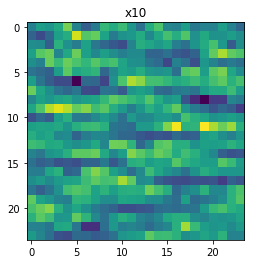

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)
    
with tf.Session() as sess:
    sess.run(iterator.initializer)
    print("retrieving one sample as numpy array (just for fun)")
    x10, doy, year, labels = sess.run(iterator.get_next())
    print("x10.shape: " + str(x10.shape))
    print("doy.shape: " + str(doy.shape))
    print("year.shape: " + str(year.shape))
    print("labels.shape: " + str(labels.shape))
    plt.imshow(x10[0,0,:,:,0])
    plt.title("x10")

# 3b Perform one training step

In [21]:
# define the network to be loaded
# if not yet created, make one with python modelzoo/seqencoder.py script, as described in the readme.md
graph="/home/roserustowicz/MTLCC-tf-fork/tmp_africa/convgru128/graph.meta"

with tf.Session() as sess:

    print("loading network graph definition")
    tf.train.import_meta_graph(graph)

    print("initializing variables, tables and the data iterator")
    sess.run([tf.global_variables_initializer(), tf.local_variables_initializer(), tf.tables_initializer(),iterator.initializer])

    print("getting one string handle from the iterator that can be fed to the network")
    iterator_handle = sess.run(iterator.string_handle())

    print("making some processing nodes accessible to python")
    def get_operation(name):
        return tf.get_default_graph().get_operation_by_name(name).outputs[0]

    iterator_handle_op = get_operation("data_iterator_handle")
    is_train_op = get_operation("is_train")
    train_op = get_operation("train_op")

    print("performing one training step")
    sess.run(train_op,feed_dict={iterator_handle_op: iterator_handle, is_train_op: True})

loading network graph definition


OSError: File /home/roserustowicz/MTLCC-tf-fork/tmp_africa/convgru128/graph.meta does not exist.